In [2]:
# import neccessary libraries for EDA phase
import pandas as pd
import numpy as np 
import math
import matplotlib.pyplot as plt 
import seaborn as sns  

In [3]:
# create connection to database to load csv 
# FYI: I could've saved it to csv and loaded it via pd.read_csv but this project is to show my understand of ETL process

import sqlite3 
db_path = r'C:\Users\dmiracju\Saftey-Risk-Analysis\database\Safety.db'
conn = sqlite3.connect(db_path)
site_exposure = pd.read_sql('SELECT * from int_site_week_hours;', conn)

In [4]:
site_exposure.head()

,site,fiscal_year,period_name,week_sum,air_incidents,hours,rate,period_over_period_pct_change,missing_flag_hours,employee_hours,contractor_hours,total_hours_worked
0,teb3,2025,2025 WK52,52,203,1651921.908,24.577433,-0.0027,1,NaN,NaN,NaN
1,teb3,2025,2025 WK51,51,201,1631332.059,24.642439,-0.0010,1,NaN,NaN,NaN
2,teb3,2025,2025 WK50,50,197,1597327.677,24.666198,-0.0027,0,36615.0551,0.0,36615.0551
3,teb3,2025,2025 WK49,49,193,1560715.121,24.732252,-0.0089,0,37833.4828,0.0,37833.4828
4,teb3,2025,2025 WK48,48,190,1522885.305,24.952634,0.0040,0,34153.6103,0.0,34153.6103


In [5]:
# merge features table from site exposure togther 

feat_site_exposure = pd.read_sql('SELECT * from feat_site_week_hours_risk', conn)

site_exposure = site_exposure.merge(feat_site_exposure, how= 'left', on = 'week_sum')

In [6]:
# remove unneccessary columns 

site_exposure.drop(columns= ['period_name', 'rate', 'period_over_period_pct_change',
                             'total_hours_worked', 'site_y', 'fiscal_year_y', 'air_incidents_y',
                             'hours', 'contractor_hours', 'employee_hours',], inplace = True)

In [7]:
# fix column label typos 
site_exposure.rename(columns = {'site_x' : 'site', 'fiscal_year_x': 'year', 
                               'air_incidents_x': 'all_incidents'}, inplace = True)

In [8]:
# view column names for correct wrangling proof 
site_exposure.columns

Index(['site', 'year', 'week_sum', 'all_incidents', 'missing_flag_hours',
       'ytd_rate', 'hours_ytd', 'incidents_weekly', 'hours_weekly',
       'incidents_4wk_avg', 'hours_4wk_avg', 'incidents_4wk_std',
       'hours_4wk_std', 'incidents_per_10k_hours_rate',
       'hours_per_incident_rate', 'hours_deviation', 'hours_deviation_pct',
       'hours_zscore_4wk', 'incident_spike_flag', 'hours_drop_flag',
       'hours_spike_flag'],
      dtype='object')

In [9]:
# find where nan values exist 
def count_nan(df):            # function name and dataframe 
    for col in df.columns:    # for every loop through a column, store columnn name into col 
        nan_count = df[col].isna().sum() # sweep for nan values and sum the amount, then store as object
        if nan_count > 0:                    # if nan values are greater than zero.... flag it 
            print(col, nan_count)            # output column name and nan count 

count_nan(site_exposure)



hours_per_incident_rate 1
hours_zscore_4wk 1


In [10]:
# I will be leaving the two defined columns with nan values alone, seeing as week 1 had no incidents
# This in business terms means week 1 was the safest week out of the year. 


In [11]:
#                            --- Exploratory Data Analysis ---

# Let's build out a threshold for incidents per 10,000 hours 
# Any incidents that occur outisde the expected range of distribution is considered high risk 

q90 = site_exposure['incidents_per_10k_hours_rate'].quantile(0.90)
q95 = site_exposure['incidents_per_10k_hours_rate'].quantile(0.95)

print(f'Incidents outside of the 90th percentile {q90}')
print(f'Incidents outside of the 95th percentile {q95}')


Incidents outside of the 90th percentile 2.0410470786438415
Incidents outside of the 95th percentile 2.5689784329992955


In [12]:
# Creating a 90th and 95th percentile risk flag and store output as an integer

site_exposure['high_risk'] = (site_exposure['incidents_per_10k_hours_rate'] >= q90).astype(int)

site_exposure['extreme_risk'] = (site_exposure['incidents_per_10k_hours_rate'] >= q95).astype(int)

site_exposure[['incidents_per_10k_hours_rate', 'high_risk', 'extreme_risk']] 

,incidents_per_10k_hours_rate,high_risk,extreme_risk
0,0.971352,0,0
1,1.176319,0,0
2,1.092521,0,0
3,0.793025,0,0
4,1.463800,0,0
5,1.371483,0,0
6,0.363852,0,0
7,1.104876,0,0
8,0.346212,0,0
9,0.729548,0,0


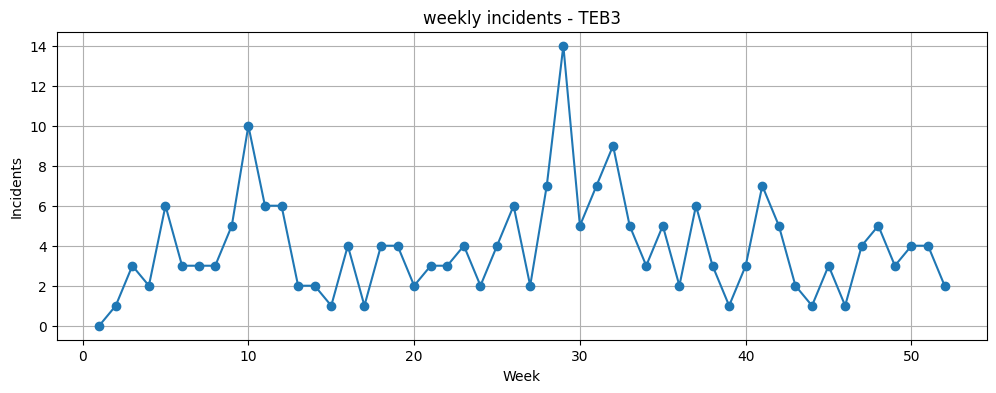

In [13]:
# Trend Exploration 

site_id = site_exposure['site'].iloc[0] # select site column value using index  

df_site = site_exposure.query('site == @site_id') # filter the dataframe to just that site 

plt.figure(figsize = (12,4)) # set plot size (prevents cramped labels)
plt.plot(
    df_site['week_sum'],      # represents time 
    df_site['incidents_weekly'],     # number of incidents in the week 
    marker = 'o')            # marks a dot at each data point 
plt.title(f'weekly incidents - {site_id.upper()}') # used f string to inject site name (also, makes the chart reusable for any site)
plt.xlabel('Week')  # x-axis label 
plt.ylabel('Incidents') # y-axis label
plt.grid(True) # makes trends and spikes easier to see 
plt.show() # displays the visual 

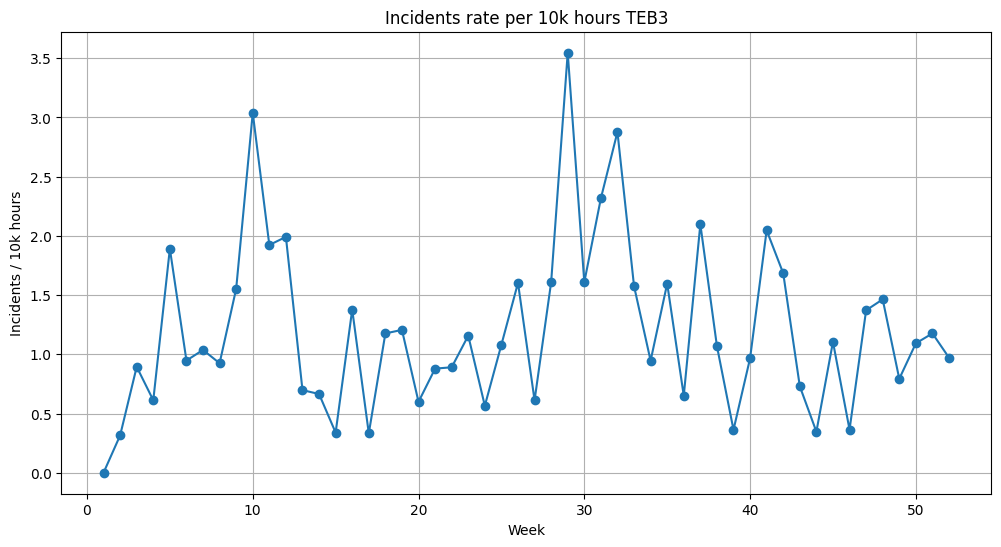

In [14]:
# incidents per 10k hours (risk normalized rate)
df_site = df_site.query('site == @site_id')

plt.figure(figsize=(12,6)) # visualiztion figure size (avoiding cramped labels and values)
plt.plot(
    df_site['week_sum'], # represents time 
    df_site['incidents_per_10k_hours_rate'],  # weekly incidents within a 10k hour time window 
    marker = 'o' # plot dots at the end of each data point
)
plt.title(f'Incidents rate per 10k hours {site_id.upper()}') # using f string to inject site name (This makes the chart become reusable for any site)
plt.xlabel('Week') # week of... 
plt.ylabel('Incidents / 10k hours') # incidents that occured within 10k hour time frame (rate)
plt.grid(True) # grid allows for better interpretability when looking at trend and spikes 
plt.show()

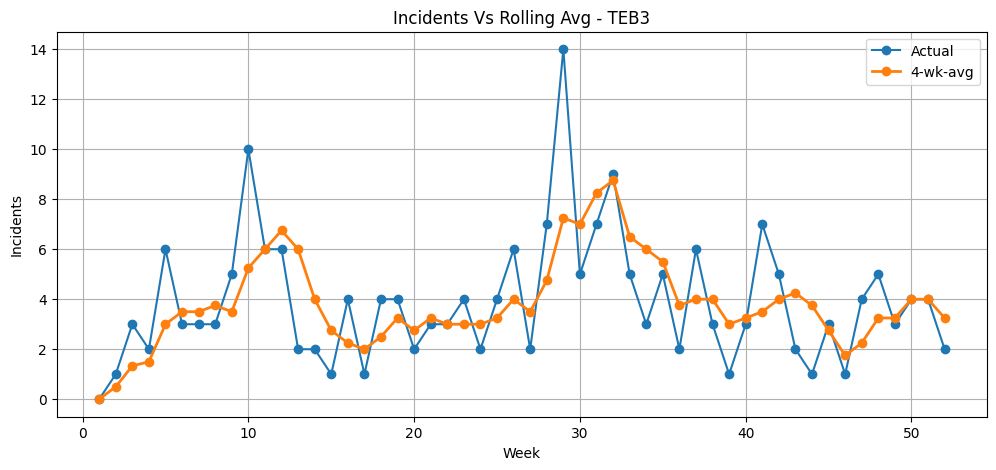

In [15]:

# Rolling behavior Vs Acutal 
plt.figure(figsize=(12,5)) # size of visualization (Great technique for avoiding cramped labels/values)
plt.plot(
    df_site['week_sum'], # represents time events occure
    df_site['incidents_weekly'], # incident count that occured during each week
    label = 'Actual',
    marker = 'o' # plot a dot at the end of each datapoint 
)
plt.plot(
    df_site['week_sum'], # represents week ncidents occured
    df_site['incidents_4wk_avg'], # incident average over a 4 week period 
    label = '4-wk-avg', 
    linewidth = 2, # makes it thicker so the smoother trend stands out 
    marker = 'o' # plot a dot at the end of each data point)
)
# Knobs 
plt.title(f'Incidents Vs Rolling Avg - {site_id.upper()}')
plt.xlabel('Week')
plt.ylabel('Incidents')
plt.legend() # converts your label text into a key so you know which line is which 
plt.grid(True)
plt.show() 

# right now visual is showing s,mal

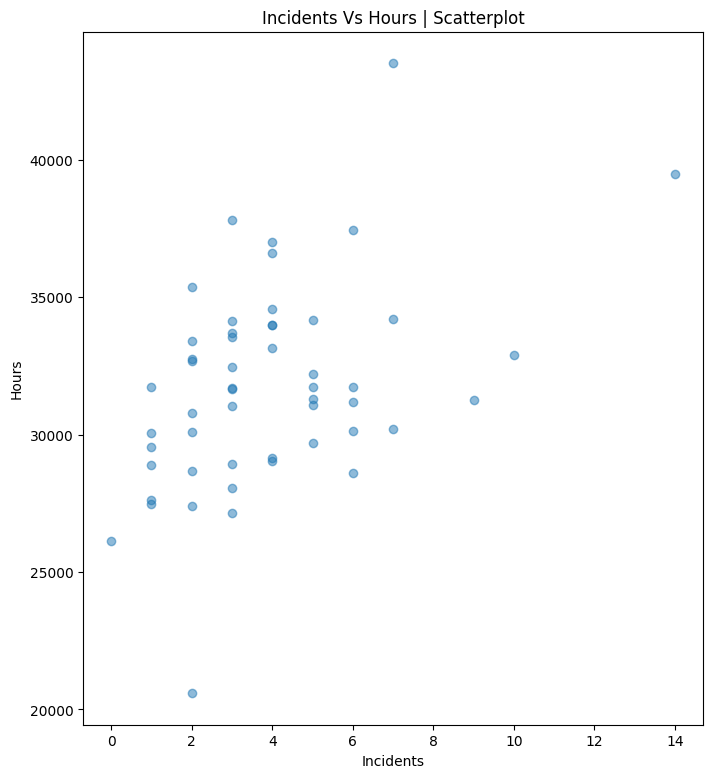

In [16]:
# look for correaltion between hours and incidents  
plt.figure(figsize=(8,9))
plt.scatter(data = df_site, x ='incidents_weekly', y ='hours_weekly', alpha= 0.5)
plt.title('Incidents Vs Hours | Scatterplot')
plt.xlabel('Incidents')
plt.ylabel('Hours')
plt.show()

In [17]:
# use the numeric correlation method to view relationship between hours and incidents 
df_site[['incidents_weekly', 'hours_weekly']].corr()

# relationship between hours and incidents seem to be moderate (let's dig futher downstream)

,incidents_weekly,hours_weekly
incidents_weekly,1.000000,0.447765
hours_weekly,0.447765,1.000000


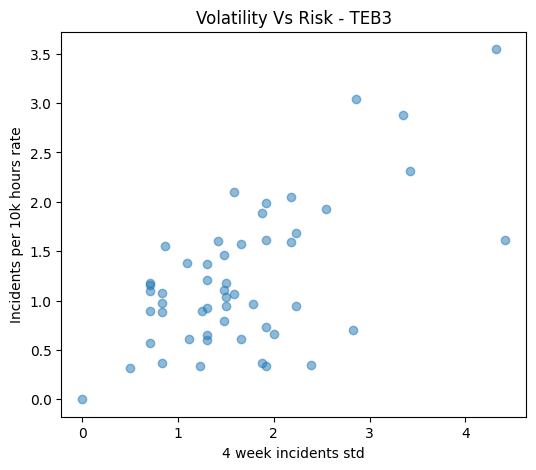

In [18]:
# Volatility Vs Risk 
plt.figure(figsize= (6,5)) # visualization size 
plt.scatter(
    df_site['incidents_4wk_std'], 
    df_site['incidents_per_10k_hours_rate'], 
    alpha= 0.5
)
plt.title(f'Volatility Vs Risk - {site_id.upper()}')
plt.xlabel('4 week incidents std')
plt.ylabel('Incidents per 10k hours rate')
plt.show()

In [19]:
# numerical output of correlation between rate and volatility 
df_site[['incidents_per_10k_hours_rate', 'incidents_4wk_std']].corr()

# higher volatility = higher risk clusters (volitlity is a legitamate feature)

,incidents_per_10k_hours_rate,incidents_4wk_std
incidents_per_10k_hours_rate,1.00000,0.62552
incidents_4wk_std,0.62552,1.00000


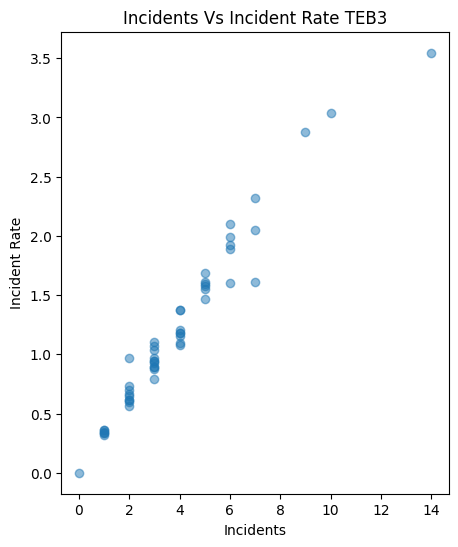

In [20]:
# rate vs raw incidents (This just shows why normalization matters )
plt.figure(figsize = (5,6)) # visualization size 
plt.scatter(           
    df_site['incidents_weekly'],   # x-axis label
    df_site['incidents_per_10k_hours_rate'], # y-axis label
    alpha=0.5   
)
plt.title(f'Incidents Vs Incident Rate {site_id.upper()}') # title name 
plt.xlabel('Incidents')
plt.ylabel('Incident Rate')
plt.show()



In [21]:
# What are the top 15 risk weeks ? 
df_site.sort_values('incidents_per_10k_hours_rate', 
                    ascending = False).head(15)

,site,year,week_sum,all_incidents,missing_flag_hours,ytd_rate,hours_ytd,incidents_weekly,hours_weekly,incidents_4wk_avg,...,incidents_per_10k_hours_rate,hours_per_incident_rate,hours_deviation,hours_deviation_pct,hours_zscore_4wk,incident_spike_flag,hours_drop_flag,hours_spike_flag,high_risk,extreme_risk
23,teb3,2025,29,113,0,23.757174,951291.597,14,39478.603,7.25,...,3.546225,2819.900214,1184.21000,0.030924,0.027067,1,0,1,1,1
42,teb3,2025,10,36,0,22.928863,314014.694,10,32910.827,5.25,...,3.038514,3291.082700,1285.34175,0.040643,0.035384,1,0,1,1,1
20,teb3,2025,32,134,0,25.673750,1043867.766,9,31279.597,8.75,...,2.877275,3475.510778,-1734.09600,-0.052527,-0.050366,1,1,0,1,1
21,teb3,2025,31,125,0,24.689208,1012588.169,7,30214.925,8.25,...,2.316736,4316.417857,-5859.30125,-0.162423,-0.156844,0,1,0,1,0
15,teb3,2025,37,155,0,25.876551,1197995.802,6,28595.505,4.00,...,2.098232,4765.917500,-2004.30300,-0.065501,-0.059188,1,1,0,1,0
11,teb3,2025,41,169,0,25.626825,1318930.460,7,34203.543,3.50,...,2.046572,4886.220429,3969.87850,0.131307,0.114518,1,0,1,1,0
40,teb3,2025,12,48,0,25.575923,375353.021,6,30130.672,6.75,...,1.991326,5021.778667,-1481.85925,-0.046876,-0.042208,0,1,0,0,0
41,teb3,2025,11,42,0,24.332144,345222.349,6,31207.655,6.00,...,1.922605,5201.275833,-985.94700,-0.030626,-0.027397,1,1,0,0,0
47,teb3,2025,5,12,0,15.400997,155834.071,6,31724.649,3.00,...,1.891274,5287.441500,-704.13300,-0.021713,-0.019283,1,1,0,0,0
10,teb3,2025,42,174,0,25.804007,1348627.770,5,29697.310,4.00,...,1.683654,5939.462000,-947.89325,-0.030931,-0.026561,1,1,0,0,0


In [22]:
# Does volatility in hours correlate with incidents ? 
df_site[['incidents_per_10k_hours_rate', 'hours_4wk_std']].corr()

# Volitilty in hours cause to some moderate degree a correlation in injuries 

,incidents_per_10k_hours_rate,hours_4wk_std
incidents_per_10k_hours_rate,1.000000,0.410768
hours_4wk_std,0.410768,1.000000


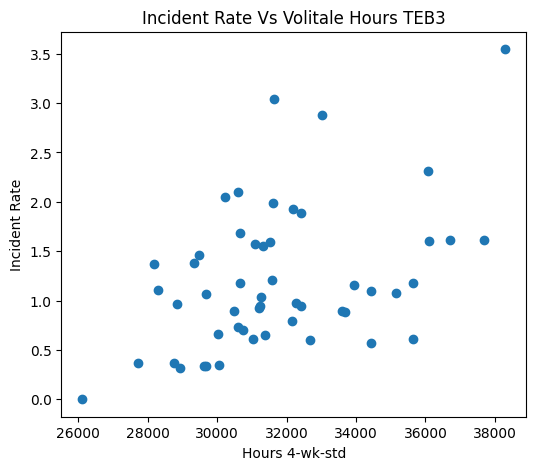

In [23]:
# plot correaltion between incident rate and volitility in hours 
plt.figure(figsize= (6,5))
plt.scatter(
    df_site['hours_4wk_avg'],   #x-axis label 
    df_site['incidents_per_10k_hours_rate'], # y-axis label
    marker = 'o',
)
plt.title(f'Incident Rate Vs Volitale Hours {site_id.upper()}') # title 
plt.xlabel('Hours 4-wk-std')
plt.ylabel('Incident Rate')
plt.show()

In [ ]:
# find percentile thresholds that meaningfully seperate risk 

percentile_50th = df_site['incidents_per_10k_hours_rate'].quantile(0.50) # low risk 
percentile_80th = df_site['incidents_per_10k_hours_rate'].quantile(0.80) # moderate risk  
percentile_90th = df_site['incidents_per_10k_hours_rate'].quantile(0.90) # high risk 
percentile_95th = df_site['incidents_per_10k_hours_rate'].quantile(0.95) # extreme risk 

print(f'50th {percentile_50th}')
print(f'80th {percentile_80th}')
print(f'90th {percentile_90th}')
print(f'95th {percentile_95th}')

50th 1.0752685158955648
80th 1.6086114786485504
90th 2.0410470786438415
95th 2.5689784329992955


In [ ]:
# calcualte how frequent high risk states occurr in TEB3 throughout the year 
risk_calc = df_site['incidents_per_10k_hours_rate'] >= percentile_90th
risk_calc.mean() * 100 # percentage of high risk for the year 

# high risk weeks make up about 40 days out of the year, or roughly 1.8 hours 

np.float64(11.538461538461538)

In [39]:
# are high risks isolated or consectutive  (Which weeks fail to recover from a high risk week)

# create a previous week high risk indicator 
df_site['prev_high_risk'] = (       
    df_site
    .groupby('site')['high_risk'] # selects risk flag
    .shift(1)     # moves values down by one (current row now see previous weeks status) Note: First row gets a nan status (no previous week)
)
# flag consecutive weeks - Logic for each row: is this week high risk and was last week also high risk? if both are true -> consecutive risk event ( 1 -> YES VS 0 -> NO)
df_site['consecutive_high_risk'] = (       
    (df_site['high_risk'] == 1) &
    (df_site['prev_high_risk'] == 1)
).astype(int)





In [40]:
df_site['consecutive_high_risk']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    1
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
Name: consecutive_high_risk, dtype: int64

In [42]:
df_site[['week_sum', 'incidents_weekly', 'consecutive_high_risk']]

,week_sum,incidents_weekly,consecutive_high_risk
0,52,2,0
1,51,4,0
2,50,4,0
3,49,3,0
4,48,5,0
5,47,4,0
6,46,1,0
7,45,3,0
8,44,1,0
9,43,2,0
